# RESNet Model Implementation

We will use the training and evaluation pipeline developed in MLP-CNN-Implementation project to train and evaluate the RESNet model. We also implement our own ResidualBlock as a new layer under the nn.Module super-class. 

### Train and apply model

- We train the RESNet model, with different values of the hyper-paramter settings. 
- We re-use the functions from model_pipeline.py which we used on MLP models.
- We describe briefly the model and your hyper-parameter setups and comment on results.

**Test Accuracy with RESNet - 93.13%**

#### Important Note: 
All the CNN file code runs on GPU. Those settings are configured in the backend file model_pipeline.py. While running the cells in this notebook, wherever there is device paramether, please change the parameter according to the OS('cuda' or'cpu') this file is being run on. Right now, it is set to 'mps' since I have Mac OS.

In [9]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
from torch import nn
from scripts.model_pipeline import mlp_train, loss_plot, mlp_apply
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### CNN Model With Residual Block 

#### Residual Block Class:
- 2 Convolution Layers with Batch Norms after each
- Dropout
- Relu

In [33]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        
        #Convolutional Layers with Batch Norm and ReLU
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.bn2 = nn.BatchNorm2d(out_channels)
         
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        ##for residual addition
        self.res = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, padding='valid')
    

    def forward(self, x):
        
        #Main path
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.pool(self.bn2(self.conv2(out)))
        x = self.res(x)
        out = out + x
        out = self.relu(out)         
        
        return out

#### CNN Model Class:
- Convolution Layer with Batch Norm and Max Pooling
- Residual Block 1
- Residual Block 2
- Average Pooling Layer
- Fully Conected Layer 

In [36]:
class CNN_Model2(nn.Module):
    
    def __init__(self, in_channels, num_classes):
        super(CNN_Model2, self).__init__()
        
        #Convolutional Layer with Batch Norm and Pooling
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding='same')
        self.bn1 = nn.BatchNorm2d(32)

        #Residual Blocks with Pooling
        self.resblock1 = ResidualBlock(32, 64)
        self.resblock2 = ResidualBlock(64, 64)
        
        self.pool = nn.AvgPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.2)
        
        #Fully Connected Layers      
        self.fc = nn.Linear(576, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.resblock1(x)
        x = self.resblock2(x)        
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flattening the tensor for the fully connected layer
        x = self.fc(x)
        
        return x

In [37]:
#Parameters
in_features = 28*28    #(1 x 28 x 28 images)
out_features = 10      #10 classes
n_epochs = 20
batch_size = 128
lr = 0.1
momentum = 0
optimizer='SGD'        #Can be 'SGD' or 'Adam' or 'RMSProp'
model_type = 'CNN'

#Data
trainset = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)
testset = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)

#Model
model = CNN_Model2(in_channels=1, num_classes=out_features)
device = torch.device("mps")   #'mps' for macbook, 'cuda' for windows or 'cpu'
model.to(device)

#Train and evaluate the model
cnn_model2, train_losses2, test_losses2, train_accuracy2, test_accuracy2 = mlp_train(model, model_type, trainset, 
                                                                                     testset, n_epochs=n_epochs, 
                                                                                     batch_size=32, 
                                                                                     optimizer_param=optimizer, 
                                                                                     optimizer_lr=lr, device=device)
print(cnn_model2)

Epoch 1/20, Train Loss: 0.3923, Train Accuracy: 85.6550, Test Loss: 0.2835, Test Accuracy: 89.7664
Epoch 2/20, Train Loss: 0.2572, Train Accuracy: 90.7350, Test Loss: 0.2417, Test Accuracy: 91.2839
Epoch 3/20, Train Loss: 0.2234, Train Accuracy: 91.9633, Test Loss: 0.2335, Test Accuracy: 91.4537
Epoch 4/20, Train Loss: 0.2038, Train Accuracy: 92.5717, Test Loss: 0.2437, Test Accuracy: 91.2839
Epoch 5/20, Train Loss: 0.1849, Train Accuracy: 93.2617, Test Loss: 0.2260, Test Accuracy: 92.0228
Epoch 6/20, Train Loss: 0.1721, Train Accuracy: 93.6117, Test Loss: 0.2110, Test Accuracy: 92.7117
Epoch 7/20, Train Loss: 0.1577, Train Accuracy: 94.2483, Test Loss: 0.2087, Test Accuracy: 92.8115
Epoch 8/20, Train Loss: 0.1479, Train Accuracy: 94.6833, Test Loss: 0.2053, Test Accuracy: 93.0012
Epoch 9/20, Train Loss: 0.1389, Train Accuracy: 94.8700, Test Loss: 0.1993, Test Accuracy: 93.1310
Epoch 10/20, Train Loss: 0.1338, Train Accuracy: 95.1783, Test Loss: 0.2132, Test Accuracy: 92.8315
Epoch 11/

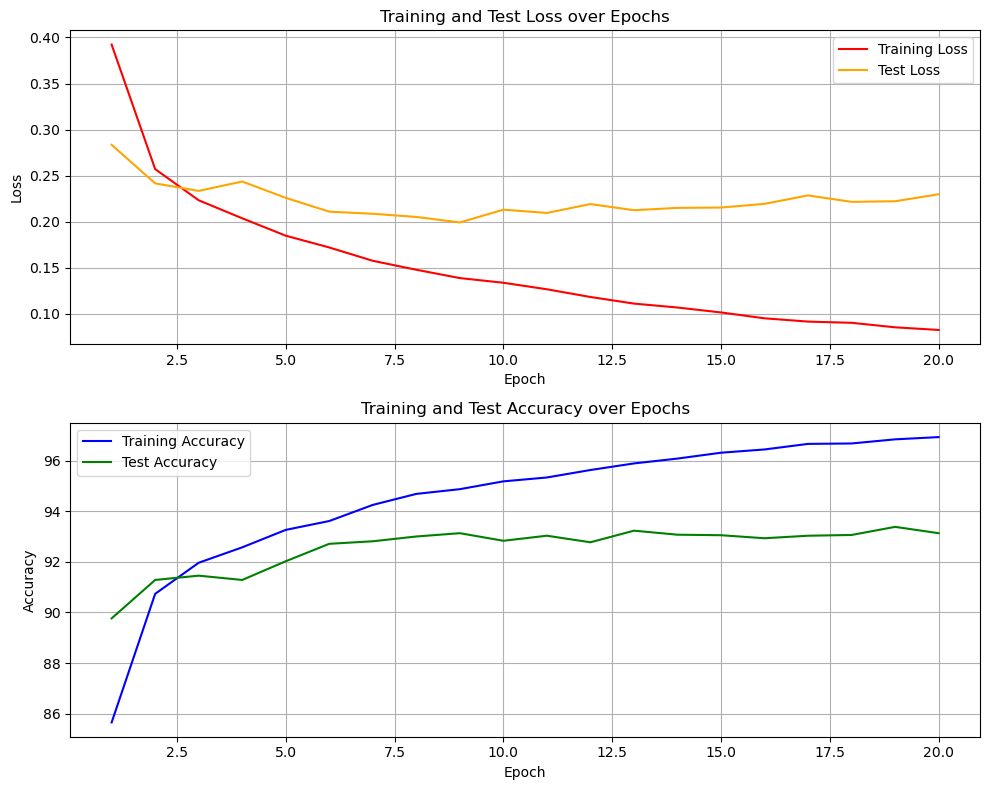

In [38]:
loss_plot(train_losses2,test_losses2,train_accuracy2,test_accuracy2,n_epochs)

In [39]:
best_model = cnn_model2

### Model application

Defined a simple utility function `mlp_apply` in /scripts/model_pipeline.py that uses the train model to classify 10 examples of the test set and displays the 10 images in a grid together with their true and predicted labels.

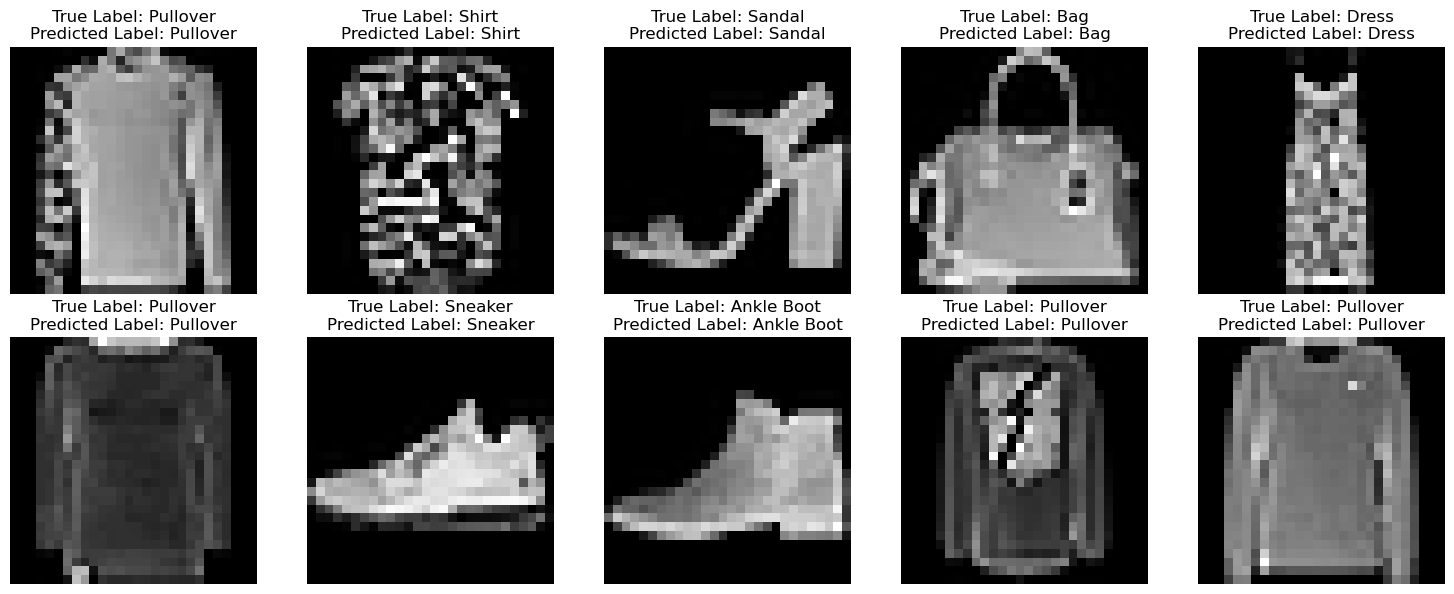

In [43]:
from scripts.model_pipeline import mlp_apply

#user parameters
test_indexes = torch.randint(0, 10000, (10,))  # list of 10 indexes - examples to extract from test set
testset = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)
model_type = 'CNN'

#Doing these sample predictions on CPU
device = torch.device('cpu')
best_model.to(device)

mlp_apply(best_model, model_type, testset, test_indexes)

### Model Description ---->

### CNN Model 2: Includes Residual Block

This model reaches the accuracy of **93.13%** in the 20th epoch. This model enables the training of the deep neural network by using residual learning and shortcut connections. We create a residual block class from nn.Module, and call these res-blocks in our main CNN architecture. We use SGD Optimiser.

Hyperparameters:
- Opimiser = SGD
- Learning rate = 0.1
- epochs = 20
- batch size = 128
- Dropout rate = 0.2


Model Architecture:

**Residual Block**: 
- Convolutional Layer 1: (32 -> 64, 3x3 kernel, stride 1, padding 'same')
- Batch Normalization: (64 features)
- ReLU Activation
- Convolutional Layer 2: (64 -> 64, 3x3 kernel, stride 1, padding 'same')
- Batch Normalization: (64 features)
- ReLU Activation
- Dropout: (p=0.2)
- Max Pooling: (2x2 kernel, stride 2)
- Residual Connection: (32 -> 64, 1x1 kernel, stride 2, padding 'valid')

**CNN Model:**
- Input: 1 channel (e.g., grayscale image)
    - Conv2d Block
    - Convolutional Layer: (1 -> 32, 3x3 kernel, stride 1, padding 'same')
    - Batch Normalization: (32 features)
    - ReLU Activation
- Residual Block 1
- Residual Block 2
- Average Pooling
    - Avg Pooling: (2x2 kernel, stride 2)
- Fully Connected Block
    - Dropout: (p=0.2)
    - Linear Layer: (576 -> 10)
    - ReLU Activation

### Discussions:

ResNet (Residual Network) often outperforms traditional CNN (Convolutional Neural Network) and MLP (Multilayer Perceptron) models on image dataset FashionMNIST for several reasons related to its architecture and the way it handles deep learning tasks. Here are the key reasons:

#### 1. **Residual Connections**
- **Vanishing Gradient Problem:** As networks become deeper, traditional models suffer from the vanishing gradient problem, where gradients become very small during backpropagation, making it hard to train the initial layers. ResNet introduces residual connections (or skip connections) that allow gradients to flow more directly through the network, mitigating this issue.
- **Identity Mapping:** The skip connections in ResNet allow the network to learn identity mappings more easily, ensuring that the performance doesn't degrade as the network depth increases. This helps in maintaining or even improving accuracy as the network gets deeper.

#### 2. **Depth**
- **Deeper Networks:** Deeper networks generally have more capacity to learn complex features and patterns in the data. ResNet enables training of very deep networks (e.g., hundreds of layers) effectively, leveraging its residual connections.
- **Hierarchical Feature Learning:** With greater depth, ResNet can learn a hierarchy of features, from simple edges in early layers to more complex textures and shapes in deeper layers, which is crucial for tasks like image classification.

#### 3. **Better Generalization**
- **Regularization Effect:** The residual connections can have a regularizing effect on the network, which helps in better generalization to new, unseen data. This is crucial for datasets like FashionMNIST where the model needs to generalize well to different types of fashion items.

#### 4. **Architecture Optimization**
- **Batch Normalization:** ResNet often incorporates batch normalization, which normalizes the input of each layer, reducing internal covariate shift and accelerating training.
- **Shortcut Connections:** The shortcut connections effectively reduce the number of layers that each gradient must propagate through during backpropagation, reducing the complexity of optimization.

#### 5. **Empirical Performance**
- **Proven Success:** ResNet has consistently shown superior performance in various benchmarks, including the more challenging ImageNet dataset. Its effectiveness on complex datasets suggests it handles simpler datasets like FashionMNIST efficiently, leveraging its robustness and ability to capture intricate patterns.


FashionMNIST is a more challenging dataset than MNIST because it involves more complex and varied patterns. ResNet’s ability to handle this complexity through deeper architectures and residual connections allows it to outperform traditional CNNs and MLPs, which might struggle to capture the intricate details of the fashion items due to their shallower nature or simpler structure.
